<div style='border-bottom: 2px solid mediumblue; padding: 0.5em;'>
    <strong style='color: mediumblue; font-size: 30px;'>ANALYSIS.</strong>
    <br>
</div>

In [277]:
import pandas as pd
import numpy as np
import sidetable
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from wordcloud import WordCloud
import re
import contractions
import spacy
from spacy.cli import download
#import spacy_transformers
#import torch


import warnings
warnings.filterwarnings('ignore')

<div style="background-color: aliceblue; border: 1.5px solid blue; border-left: 5px solid blue; padding: 0.8em; font-size: 20px">
<strong>1. DATA INFORMATION AND DATA LOADING</strong>
</div>

The data for this project comes from XML files available at this [link](https://github.com/abachaa/LiveQA_MedicalTask_TREC2017/tree/master).
These files are related to the TREC-2017 LiveQA Medical Question Answering Task. The LiveQA'17 medical task focuses on answering consumer health questions. We use health questions received by the U.S. National Library of Medicine (NLM).

<div style="background-color: blanchedalmond; border: 1.5px solid darkorange; border-left: 5px solid darkorange; padding: 0.5em; font-size: 16px">
<strong>1.1. JSON Data Loading</strong>
</div>

We have converted the XML file to JSON.

In [228]:
df = pd.read_json('../data/json/train_cleaned.json')

<div style="background-color: blanchedalmond; border: 1.5px solid darkorange; border-left: 5px solid darkorange; padding: 0.5em; font-size: 16px">
<strong>1.2. Transformation of JSON to Tabular Structure</strong>
</div>

In [229]:
df.head()

,nlm_question
0,"{'subject': 'Lyme Disease', 'message': '12 yea..."
1,"{'subject': 'Raynauds Syndrome', 'message': 'M..."
2,"{'subject': 'burn to my wrist', 'message': 'He..."
3,"{'subject': 'treatment of parkinson', 'message..."
4,{'subject': 'Periventricular Heterotopia. Sco...


We are extracting data from the JSON file into different columns of a DataFrame.

In [230]:
df = pd.json_normalize(df['nlm_question'])

In [231]:
df.head()

,subject,message,qid,f_ref,sub_questions.sub_question
0,Lyme Disease,12 years ago I was bitten by tick while deer h...,1.0,None,"[{'annotations': {'focus': ['Lyme Disease'], '..."
1,Raynauds Syndrome,My sons middle toe turned white after being in...,2.0,None,[{'annotations': {'focus': ['Raynauds Syndrome...
2,burn to my wrist,Hello I burnt my wrist 2 days ago and after la...,5.0,None,"[{'annotations': {'focus': ['burn'], 'type_val..."
3,treatment of parkinson,I AM HAVING PARKINSON FOR LAST 8 YEARS. SO FAR...,6.0,None,"[{'annotations': {'focus': ['Parkinson'], 'typ..."
4,Periventricular Heterotopia. Scoliosis - pos...,Question in laymen terms: Has any genetic or o...,8.0,None,[{'annotations': {'focus': ['Periventricular H...


In [232]:
df.shape

(446, 5)

In [233]:
print(df['sub_questions.sub_question'][0])

[{'annotations': {'focus': ['Lyme Disease'], 'type_value': 'Information'}, 'answers': {'answer': [{'value': 'Lyme disease tests are used to determine if a person with characteristic symptoms has been infected by Borrelia burgdorferi. If the doctor suspects a recent infection, then she may order both an IgM and IgG antibody blood test. If they are negative but symptoms persist, then the tests may be ordered again a few weeks later…Lyme disease can sometimes be challenging to diagnose', 'answerid': None, 'pairid': None}]}, 'subqid': None}]


In [234]:
expanded_sub_questions = pd.json_normalize(df['sub_questions.sub_question'].explode())

In [235]:
# We join expanded df with original df
df = df.drop(columns=['sub_questions.sub_question']).join(expanded_sub_questions)

In [236]:
df.head()

,subject,message,qid,f_ref,subqid,annotations.focus,annotations.type_value,answers.answer
0,Lyme Disease,12 years ago I was bitten by tick while deer h...,1.0,None,None,[Lyme Disease],Information,[{'value': 'Lyme disease tests are used to det...
1,Raynauds Syndrome,My sons middle toe turned white after being in...,2.0,None,None,[Raynauds Syndrome],Symptom,[{'value': 'Only one finger or toe or parts of...
2,burn to my wrist,Hello I burnt my wrist 2 days ago and after la...,5.0,None,None,[burn],Treatment,"[{'value': 'Before giving first aid, it is imp..."
3,treatment of parkinson,I AM HAVING PARKINSON FOR LAST 8 YEARS. SO FAR...,6.0,None,None,[Parkinson],Treatment,[{'value': 'you should know that people who ha...
4,Periventricular Heterotopia. Scoliosis - pos...,Question in laymen terms: Has any genetic or o...,8.0,None,None,[Periventricular Heterotopia/ Scoliosis],information,[{'value': 'Isolated lissencephaly sequence (I...


In [237]:
print(df['answers.answer'][0])

[{'value': 'Lyme disease tests are used to determine if a person with characteristic symptoms has been infected by Borrelia burgdorferi. If the doctor suspects a recent infection, then she may order both an IgM and IgG antibody blood test. If they are negative but symptoms persist, then the tests may be ordered again a few weeks later…Lyme disease can sometimes be challenging to diagnose', 'answerid': None, 'pairid': None}]


In [238]:
expanded_answers = pd.json_normalize(df['answers.answer'].explode())

In [239]:
df = df.drop(columns=['answers.answer']).join(expanded_answers)

In [240]:
df.head()

,subject,message,qid,f_ref,subqid,annotations.focus,annotations.type_value,value,answerid,pairid
0,Lyme Disease,12 years ago I was bitten by tick while deer h...,1.0,None,None,[Lyme Disease],Information,Lyme disease tests are used to determine if a ...,None,NaN
1,Raynauds Syndrome,My sons middle toe turned white after being in...,2.0,None,None,[Raynauds Syndrome],Symptom,Only one finger or toe or parts of one or more...,None,NaN
2,burn to my wrist,Hello I burnt my wrist 2 days ago and after la...,5.0,None,None,[burn],Treatment,"Before giving first aid, it is important to de...",None,NaN
3,treatment of parkinson,I AM HAVING PARKINSON FOR LAST 8 YEARS. SO FAR...,6.0,None,None,[Parkinson],Treatment,you should know that people who have Parkinson...,None,NaN
4,Periventricular Heterotopia. Scoliosis - pos...,Question in laymen terms: Has any genetic or o...,8.0,None,None,[Periventricular Heterotopia/ Scoliosis],information,Isolated lissencephaly sequence (ILS) is a con...,None,NaN


We have two columns corresponding to the patient’s query: 'subject' and 'message,' and three columns generated with the responses: 'focus,' 'type_value,' and 'value,' which represent the category and response to the query. The remaining questions are for identification purposes.

We are going to explore the 'focus' column, as it is a list.

In [241]:
df[df['annotations.focus'].apply(lambda x: len(x) > 1)]

,subject,message,qid,f_ref,subqid,annotations.focus,annotations.type_value,value,answerid,pairid
412,,polymicrogyria. My 16 month old son has this. ...,Q167,87,Q127-S1,"[hepatitis c, vitamin E]",association,Williams syndrome is a developmental disorder ...,Q90-S1-A1,217.0
420,help,I have back pain. Please help.,Q175,18410,Q135-S1,"[ibs, PTSD]",association,These resources address the diagnosis or manag...,Q95-S1-A2,230.0


We only have 2 rows with more than one element in the list. However, some rows have the elements separated by '/'.

We decide to transform the list into a string, keeping all the parameters separated by ','.

In [242]:
df['annotations.focus'] = df['annotations.focus'].apply(lambda x: ' '.join(x))

In [243]:
df['annotations.focus'] = df['annotations.focus'].apply(lambda x: x.replace('/', ', '))

In [244]:
df.head()

,subject,message,qid,f_ref,subqid,annotations.focus,annotations.type_value,value,answerid,pairid
0,Lyme Disease,12 years ago I was bitten by tick while deer h...,1.0,None,None,Lyme Disease,Information,Lyme disease tests are used to determine if a ...,None,NaN
1,Raynauds Syndrome,My sons middle toe turned white after being in...,2.0,None,None,Raynauds Syndrome,Symptom,Only one finger or toe or parts of one or more...,None,NaN
2,burn to my wrist,Hello I burnt my wrist 2 days ago and after la...,5.0,None,None,burn,Treatment,"Before giving first aid, it is important to de...",None,NaN
3,treatment of parkinson,I AM HAVING PARKINSON FOR LAST 8 YEARS. SO FAR...,6.0,None,None,Parkinson,Treatment,you should know that people who have Parkinson...,None,NaN
4,Periventricular Heterotopia. Scoliosis - pos...,Question in laymen terms: Has any genetic or o...,8.0,None,None,"Periventricular Heterotopia, Scoliosis",information,Isolated lissencephaly sequence (ILS) is a con...,None,NaN


In [245]:
rows_with_2_focus = len(df[df['annotations.focus'].str.contains(',')])
print(f'We have {rows_with_2_focus} rows with two focus.')

We have 28 rows with two focus.


<div style="background-color: aliceblue; border: 1.5px solid blue; border-left: 5px solid blue; padding: 0.8em; font-size: 20px">
<strong>2. DATA EXPLORATION AND CLEANING</strong>
</div>

In [246]:
df.dtypes

subject                    object
message                    object
qid                        object
f_ref                      object
subqid                     object
annotations.focus          object
annotations.type_value     object
value                      object
answerid                   object
pairid                    float64
dtype: object

In [247]:
df['annotations.type_value'].unique()

array(['Information', 'Symptom', 'Treatment', 'information',
       'Complication', 'Indication', 'Diagnosis', 'Organization',
       'Susceptibility', 'Prognosis', 'Cause', 'Diagnose_me',
       'Association', 'susceptibility', 'treatment', 'contraindication',
       'cause', 'symptom', 'genetic changes', 'inheritance', 'resources',
       'prevention', 'diagnosis', 'prognosis', 'complication', 'tapering',
       'side effects', 'dosage', 'association', 'indication'],
      dtype=object)

In [248]:
# We notice that some values are repeated except for the capitalization, so we convert the column to lowercase.
df['annotations.type_value'] = df['annotations.type_value'].apply(lambda x: x.lower())

In [249]:
df['annotations.type_value'].unique()

array(['information', 'symptom', 'treatment', 'complication',
       'indication', 'diagnosis', 'organization', 'susceptibility',
       'prognosis', 'cause', 'diagnose_me', 'association',
       'contraindication', 'genetic changes', 'inheritance', 'resources',
       'prevention', 'tapering', 'side effects', 'dosage'], dtype=object)

In [250]:
len(df['annotations.type_value'].unique())

20

We see that we have similar types, such as 'diagnosis' and 'diagnose_me'. We explore this.

In [251]:
df[df['annotations.type_value'] == 'diagnose_me']

,subject,message,qid,f_ref,subqid,annotations.focus,annotations.type_value,value,answerid,pairid
38,Need help!,I have a knot about the size of a BB in my rig...,55.0,None,None,a knot about the size of a BB in my right forearm,diagnose_me,It is arm lump? An arm lump is a protuberance...,None,NaN


'diagnose_me' contains only one record and refers to diagnosis, so we group this row under 'diagnosis'.

In [252]:
df['annotations.type_value'] = df['annotations.type_value'].apply(lambda x: x.replace('diagnose_me', 'diagnosis'))

In [253]:
df.duplicated().sum()

0

In [254]:
df.stb.missing()

,missing,total,percent
f_ref,246,446,55.156951
subqid,246,446,55.156951
answerid,246,446,55.156951
pairid,246,446,55.156951
subject,0,446,0.000000
message,0,446,0.000000
qid,0,446,0.000000
annotations.focus,0,446,0.000000
annotations.type_value,0,446,0.000000
value,0,446,0.000000


In [255]:
df['f_ref'].unique()[:30]

array([None, '11373', '1-136434885', '1-123453375', '1-118260435',
       '1-132032443', '17730', '1-123897705', '1-133748113',
       '1-134322567', '1-135752923', '19832', '1-136400295',
       '1-131374625', '1-133026625', '1-135900462', '13550',
       '1-136744885', '1-132036525', '1-120034865', '13506',
       '1-136858845', '5288', '1-136022315', '1-135934082', 'NF_61',
       '14262', '1-136961537', '1-134470695', '1-132036455'], dtype=object)

In [256]:
df['subqid'].unique()[:30]

array([None, 'Q1-S1', 'Q2-S1', 'Q3-S1', 'Q4-S1', 'Q5-S1', 'Q6-S1',
       'Q6-S2', 'Q7-S1', 'Q8-S1', 'Q9-S1', 'Q10-S1', 'Q11-S1', 'Q11-S2',
       'Q12-S1', 'Q13-S1', 'Q14-S1', 'Q15-S1', 'Q16-S1', 'Q17-S1',
       'Q17-S2', 'Q18-S1', 'Q18-S2', 'Q19-S1', 'Q20-S1', 'Q21-S1',
       'Q22-S1', 'Q23-S1', 'Q24-S1', 'Q25-S1'], dtype=object)

In [257]:
df['answerid'].unique()[:30]

array([None, 'Q1-S1-A1', 'Q1-S1-A2', 'Q2-S1-A1', 'Q2-S1-A2', 'Q3-S1-A1',
       'Q4-S1-A1', 'Q5-S1-A1', 'Q6-S1-A1', 'Q6-S1-A2', 'Q6-S1-A3',
       'Q6-S2-A1', 'Q6-S2-A2', 'Q7-S1-A1', 'Q8-S1-A1', 'Q9-S1-A1',
       'Q10-S1-A1', 'Q10-S1-A2', 'Q11-S1-A1', 'Q11-S2-A1', 'Q12-S1-A1',
       'Q13-S1-A1', 'Q14-S1-A1', 'Q15-S1-A1', 'Q15-S1-A2', 'Q15-S1-A3',
       'Q16-S1-A1', 'Q17-S1-A1', 'Q17-S2-A1', 'Q18-S1-A1'], dtype=object)

In [258]:
df['pairid'].unique()[:30]

array([nan,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 23., 25., 26., 27., 30.,
       36., 37., 38., 39.])

These columns does not contribute to our model, so we delete them.

In [259]:
df.drop(['f_ref', 'subqid', 'answerid', 'pairid'], axis=1, inplace=True)

We will rename and reorganize the remaining columns to enhance the clarity of the DataFrame.

In [260]:
df = df.rename(columns={'subject': 'subject',
                        'message': 'message',
                        'qid': 'qid',
                        'annotations.focus': 'focus',
                        'annotations.type_value': 'category',
                        'value': 'answer'
                        })

In [261]:
df = df[['qid', 'subject', 'message', 'focus', 'category', 'answer']]

<div style="background-color: blanchedalmond; border: 1.5px solid darkorange; border-left: 5px solid darkorange; padding: 0.5em; font-size: 16px">
<strong>1.1. Exploring columns</strong>
</div>

We will explore the distribution of the different categories graphically.

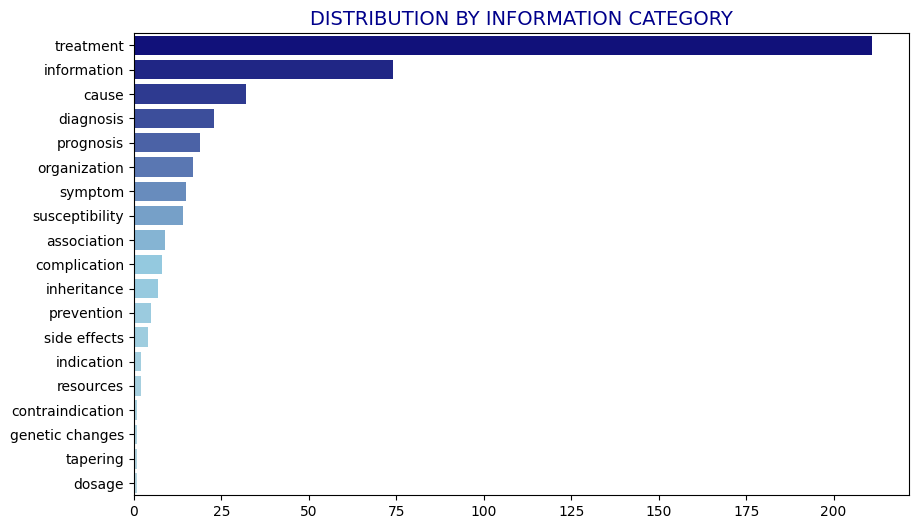

In [262]:
my_countplot_palette = LinearSegmentedColormap.from_list('Gradient', ['darkblue', 'skyblue', 'lightblue'])
num_bars = (len(df['category'].unique()))

plt.figure(figsize=(10, 6))
sns.countplot(y='category',
            data=df, palette= my_countplot_palette(np.linspace(0, 1, num_bars)),
            order=df['category'].value_counts().index)

plt.title('DISTRIBUTION BY INFORMATION CATEGORY', color='darkblue', fontsize=14)
plt.xlabel('')
plt.ylabel('')

plt.show()

We will analyze the 'subject' and 'message' columns, as they contain empty records.

In [263]:
df[df['subject'].str.len() == 0]

,qid,subject,message,focus,category,answer
5,9.0,,WHAT IS THE LATTEST RESEARCH ON USING D-Limone...,skin cancer,treatment,Treatment options depend on the following: Th...
20,32.0,,"Are large, inoperable schwannomas treatable or...",schwannomas,treatment,How is a vestibular schwannoma treated?s the t...
21,33.0,,I want more information on Hypertension and fi...,Hypertension,information,"Ordinarily, in healthy, pain-free people, the ..."
22,35.0,,Hello i would like more info about Familial Me...,familial mediterranean fever,information,What is familial Mediterranean fever? Familia...
23,36.0,,I just read an article submitted by you that s...,burning mouth syndrome,treatment,Treatment Your doctor will help you get reli...
...,...,...,...,...,...,...
428,Q183,,Kartagener's syndrome. I am suffering from Kar...,keloids,treatment,Treatment may not be needed unless the tremors...
429,Q184,,can I use 1yr expired Ciprofloxacin Ophthalmic?,rheumatoid arthritis,treatment,Treatment for essential tremor may not be nece...
440,Q195,,If both parents carry the EVC gene which is re...,dry mouth,treatment,Leukemia is a cancer of the blood cells. It is...
441,Q196,,Is there any information regarding adults havi...,inguinal hernia,information,Sometimes people inherit DNA mutations from a ...


In [266]:
df[df['message'].str.len() == 0]

,qid,subject,message,focus,category,answer
58,78.0,sir my testicular is small in size another is ...,,testicular is small in size,treatment,Treatment of male hypogonadism/androgen defici...
67,87.0,Trigem Neuralgia,,Trigem Neuralgia,cause,What is Trigeminal Neuralgia? The presumed cau...


In [267]:
df['subject'] = df['subject'].apply(lambda x: x.lower())
df['focus'] = df['focus'].apply(lambda x: x.lower())

Now that we have processed and cleaned the data, we will make the modifications for the classifier.

We want to create embeddings with the data collected from the user, which includes the 'subject' and 'message' columns. To better handle the data, we will combine them into a single column that consolidates all the information.

In [269]:
df['user_query'] = df['subject'] + ' ' + df['message']

In [270]:
nlp = spacy.load('en_core_web_lg')

We apply text cleaning to the column, removing contractions, stopwords, and so on.

In [271]:
def clean_query(query):
    """
    Cleans the given query text by performing preprocessing steps.

    Args:
        query (str): The input query text to be cleaned.

    Returns:
        str: The cleaned query text.
    """

    if not query:
        return ''

    # Convert the text to lowercase.
    query = query.lower()

    # Expand contractions in the text.
    query = contractions.fix(query)

    # Remove leading and trailing spaces, and reduce multiple spaces to a single space.
    query = query.strip()
    query = re.sub(r'\s+', ' ', query)

    # Remove all characters that are not alphanumeric or whitespace.
    query = re.sub(r'[^a-z0-9\s]', '', query)

    # Perform lemmatization and remove stopwords using spacy.
    doc = nlp(query)
    query = ' '.join([token.lemma_ for token in doc if not token.is_stop])

    return query

In [274]:
df['user_query'] = df['user_query'].apply(clean_query)

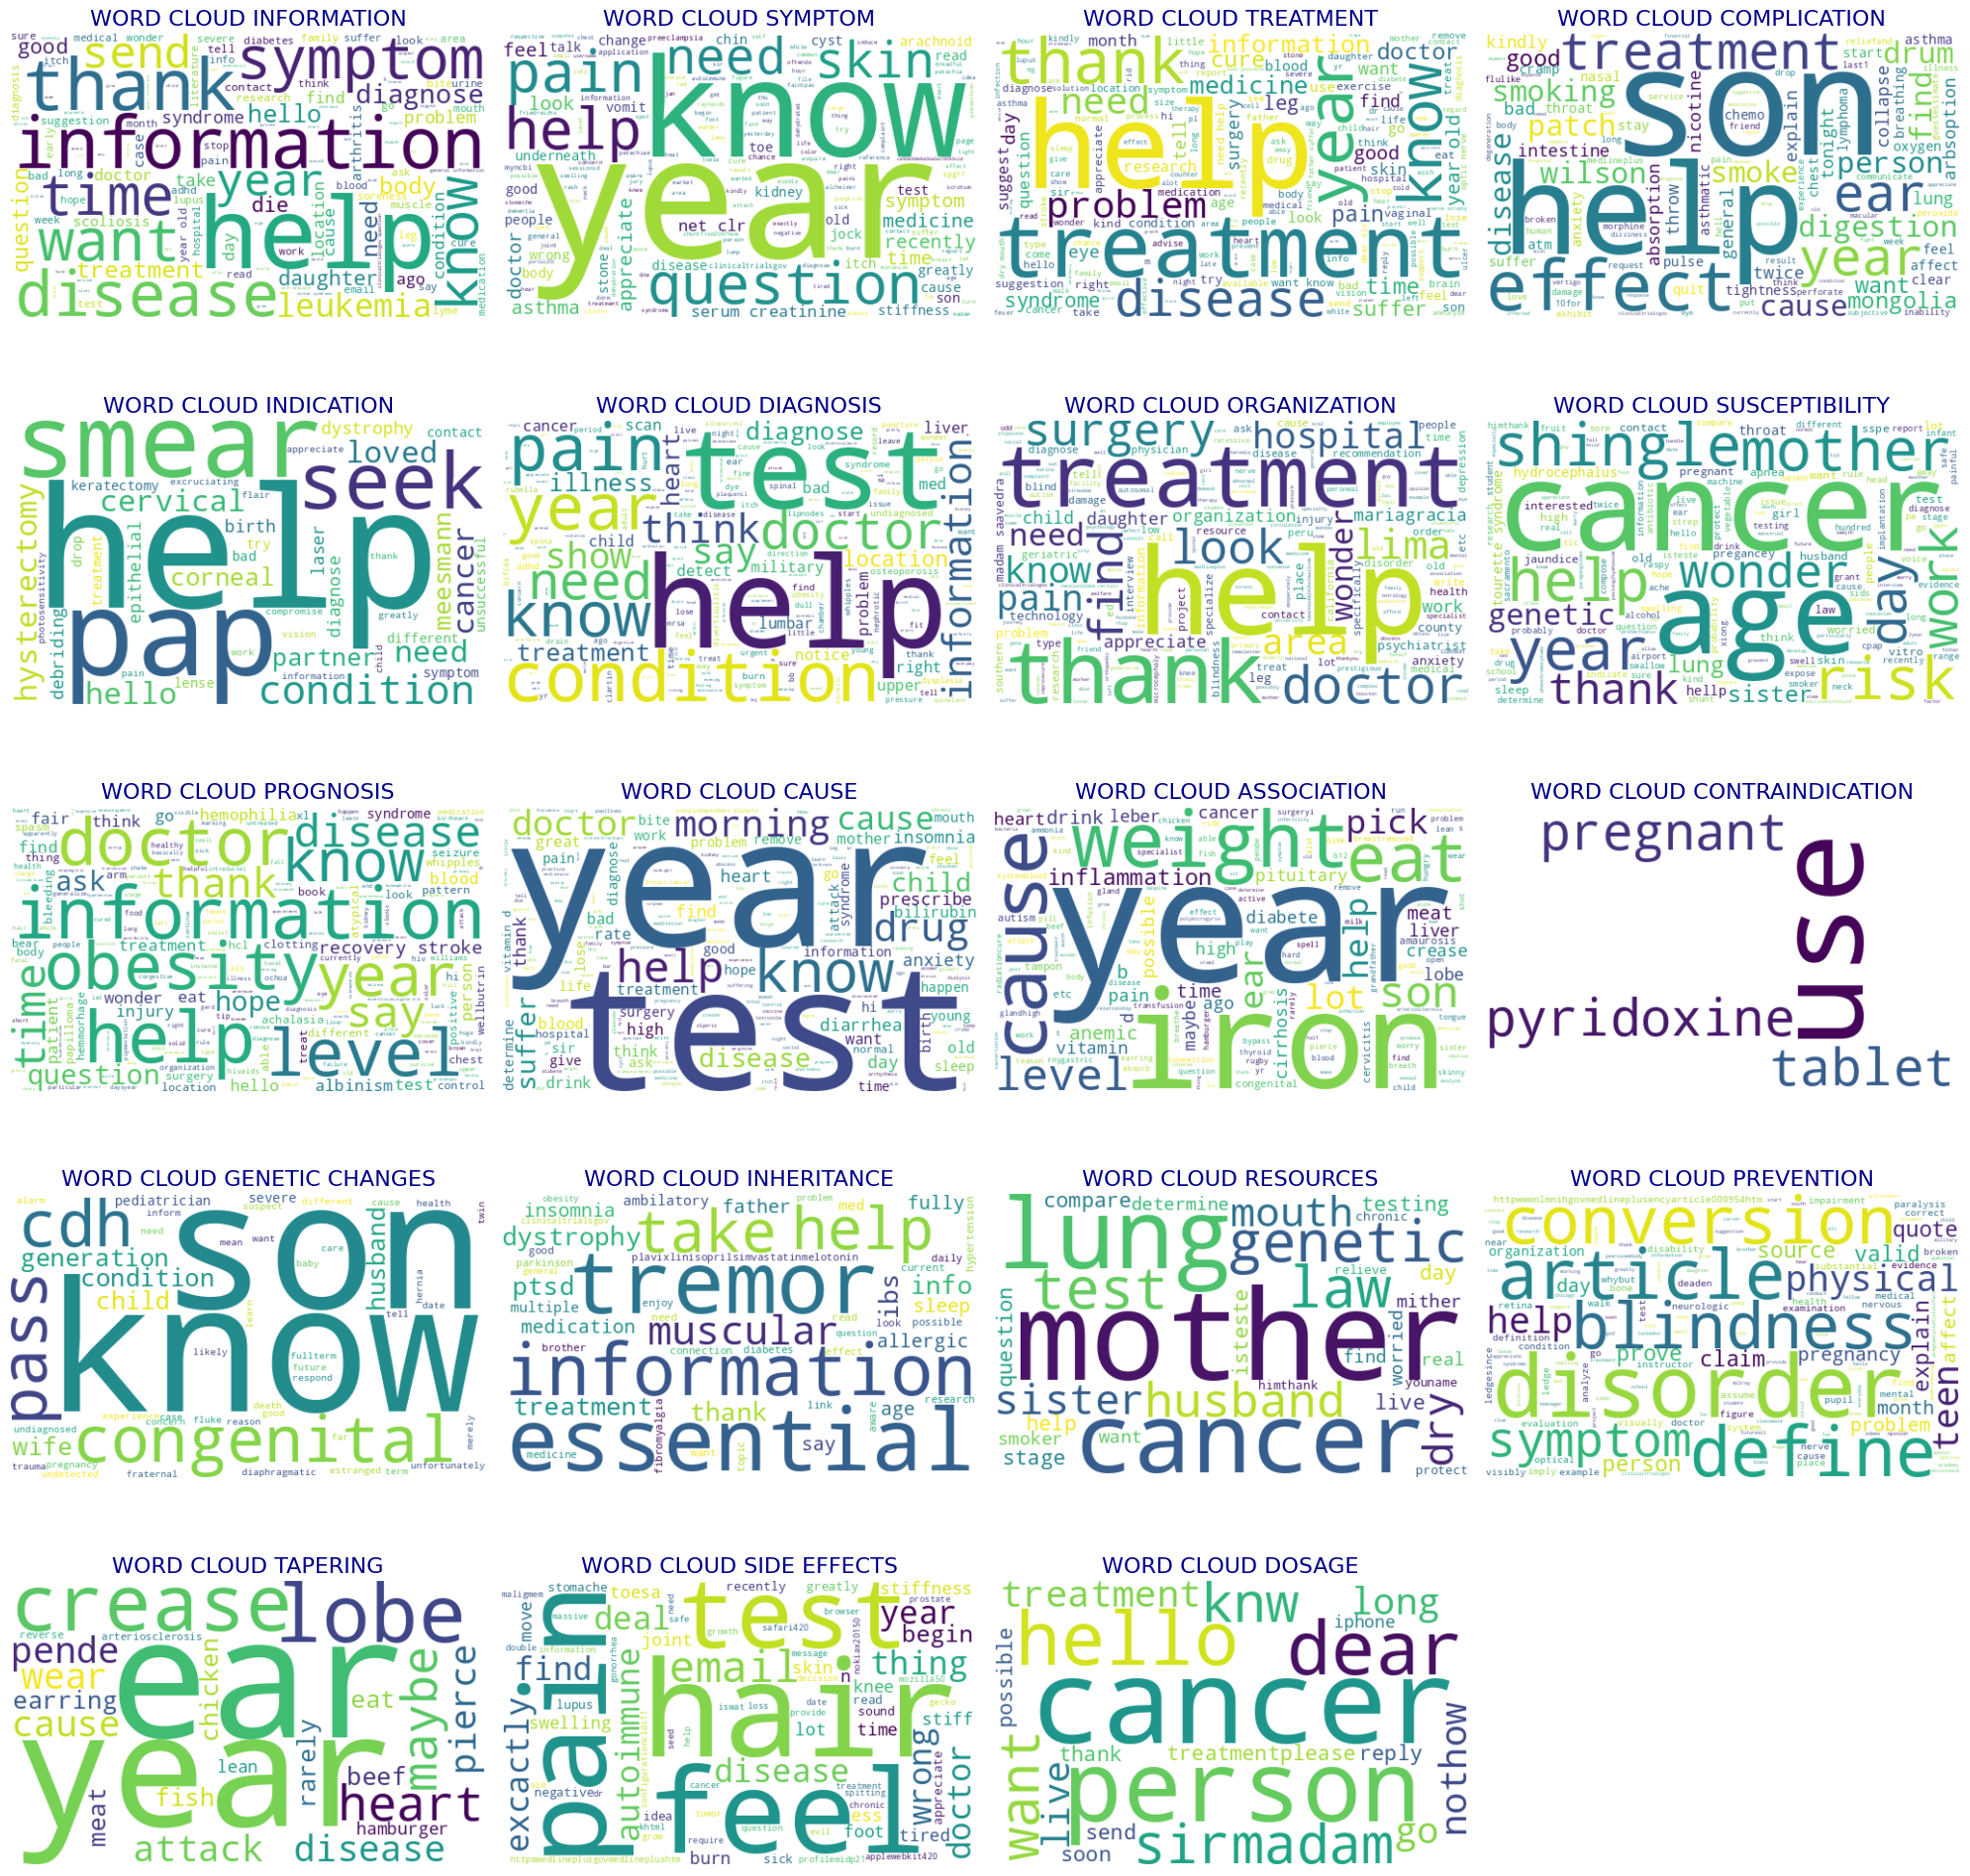

In [275]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 20))

for i, label in enumerate(df['category'].unique()):
    queries = df[df['category'] == label]['user_query']   
    text = ' '.join(queries)
    wordcloud = WordCloud(width=500, height=300, background_color='white').generate(text)
    row = i // 4
    col = i % 4   
    ax = axes[row, col]   
    ax.imshow(wordcloud, interpolation='bilinear') 
    title_wc = 'WORD CLOUD ' + label.upper()
    ax.set_title(title_wc, fontsize=16, color='darkblue')
    ax.axis('off')

fig.delaxes(axes[-1, -1])

plt.tight_layout()

plt.show()

In [276]:
df.head()

,qid,subject,message,focus,category,answer,user_query
0,1.0,lyme disease,12 years ago I was bitten by tick while deer h...,lyme disease,information,Lyme disease tests are used to determine if a ...,lyme disease 12 year ago bite tick deer hunt b...
1,2.0,raynauds syndrome,My sons middle toe turned white after being in...,raynauds syndrome,symptom,Only one finger or toe or parts of one or more...,raynauds syndrome son middle toe turn white do...
2,5.0,burn to my wrist,Hello I burnt my wrist 2 days ago and after la...,burn,treatment,"Before giving first aid, it is important to de...",burn wrist hello burn wrist 2 day ago night wa...
3,6.0,treatment of parkinson,I AM HAVING PARKINSON FOR LAST 8 YEARS. SO FAR...,parkinson,treatment,you should know that people who have Parkinson...,treatment parkinson have parkinson 8 year far ...
4,8.0,periventricular heterotopia. scoliosis - pos...,Question in laymen terms: Has any genetic or o...,"periventricular heterotopia, scoliosis",information,Isolated lissencephaly sequence (ILS) is a con...,periventricular heterotopia scoliosis possib...


In [273]:
df.to_csv('../data/csv/train_dataset/df_clean.csv')